<a href="https://colab.research.google.com/github/Ayazdani1997/AI-Spring-99-CA5/blob/master/Recitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


import time
from datetime import timedelta
from datetime import datetime

In [2]:

class ToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""

    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

In [3]:
transform = ToTensor()

In [4]:
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True, num_workers=16)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False, num_workers=16)

In [6]:
classes = train_set.classes

In [7]:
def get_number_distribution(loader, classes):
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
      total_category_count[ classes[label] ] += 1
  for category in classes:
    print('%s : %d' % (category, total_category_count[category]))

In [8]:
get_number_distribution(train_loader, classes)

0 - zero : 5923
1 - one : 6742
2 - two : 5958
3 - three : 6131
4 - four : 5842
5 - five : 5421
6 - six : 5918
7 - seven : 6265
8 - eight : 5851
9 - nine : 5949


In [9]:
get_number_distribution(test_loader, classes)

0 - zero : 980
1 - one : 1135
2 - two : 1032
3 - three : 1010
4 - four : 982
5 - five : 892
6 - six : 958
7 - seven : 1028
8 - eight : 974
9 - nine : 1009


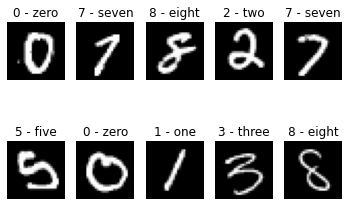

In [31]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(2, 5) 
    for i in range(2):
      for j in range(5):
        axs[i][j].imshow(img_array[i * 5 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 5 + j]])
        axs[i][j].axis('off')
    plt.show()

data_iter = iter(train_loader)
data_iter.next()
images, labels = data_iter.next()

imshow(images[0:10], labels[0:10], classes)

In [10]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):
        super(Model, self).__init__()


        self.layer1 = nn.Linear(1 * 28 * 28, 16 * 12 * 12)
        self.act1 = act


        self.layer2 = nn.Linear(16 * 12 * 12, 48 * 4 * 4)
        self.act2 = act



        self.layer3 = nn.Linear(48 * 4 * 4, 96 * 2 * 2)
        self.act3 = act


        self.layer4 = nn.Linear(96 * 2 * 2, 82)
        self.act4 = act

        self.layer5 = nn.Linear(82, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
print(device)

cuda:0


In [0]:
model = Model(len(classes))

model = model.to(device)

In [0]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [0]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))

In [0]:
def test_model_accuracy(model, test_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))

In [0]:
fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 1.913, time elapsed: 8.080973
epoch 2, train_loss: 0.463, time elapsed: 7.811836
epoch 3, train_loss: 0.291, time elapsed: 7.848515
epoch 4, train_loss: 0.212, time elapsed: 8.002004
epoch 5, train_loss: 0.162, time elapsed: 7.968798
epoch 6, train_loss: 0.130, time elapsed: 7.974235
epoch 7, train_loss: 0.107, time elapsed: 7.992479
epoch 8, train_loss: 0.090, time elapsed: 7.951098
epoch 9, train_loss: 0.076, time elapsed: 7.838857
epoch 10, train_loss: 0.065, time elapsed: 7.87459
total training time: 1.322 minutes


In [0]:
test_model_accuracy(model, test_loader)

Accuracy: 97.27%
